# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:08<00:00, 7.06kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
import helper
data_dir = './data'

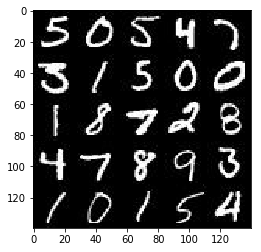

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

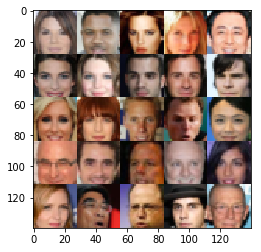

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/face-generation-project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    LearningRate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, LearningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, 0.7)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, 0.7)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, 0.7)
        # 4x4x256 now

        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.nn.dropout(relu1, 0.7)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(drop1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, 0.7)
        # 7x7x256 now
        
      
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, 0.7)
        # 14x14x128 now
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(drop3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                #Rescaling images from (-0.5,0.5) to (-1,1)
                batch_images = batch_images * 2

                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:                
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)
           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/0... Discriminator Loss: 1.9195... Generator Loss: 0.2564
Epoch 1/0... Discriminator Loss: 1.2645... Generator Loss: 0.6034
Epoch 1/0... Discriminator Loss: 1.5875... Generator Loss: 0.5239
Epoch 1/0... Discriminator Loss: 1.2088... Generator Loss: 0.7959
Epoch 1/0... Discriminator Loss: 1.2052... Generator Loss: 0.6717
Epoch 1/0... Discriminator Loss: 1.2893... Generator Loss: 0.8843
Epoch 1/0... Discriminator Loss: 1.1830... Generator Loss: 0.9997
Epoch 1/0... Discriminator Loss: 1.1318... Generator Loss: 1.1131
Epoch 1/0... Discriminator Loss: 1.2479... Generator Loss: 1.2058
Epoch 1/0... Discriminator Loss: 1.3165... Generator Loss: 0.4963


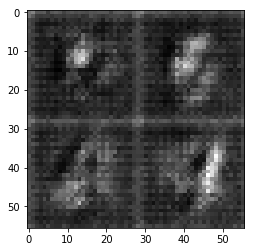

Epoch 1/0... Discriminator Loss: 1.1629... Generator Loss: 0.8953
Epoch 1/0... Discriminator Loss: 1.2291... Generator Loss: 0.6167
Epoch 1/0... Discriminator Loss: 1.1966... Generator Loss: 0.8491
Epoch 1/0... Discriminator Loss: 1.2491... Generator Loss: 0.5818
Epoch 1/0... Discriminator Loss: 1.1868... Generator Loss: 1.0501
Epoch 1/0... Discriminator Loss: 1.1765... Generator Loss: 0.7251
Epoch 1/0... Discriminator Loss: 1.1532... Generator Loss: 1.0681
Epoch 1/0... Discriminator Loss: 1.1358... Generator Loss: 0.8170
Epoch 1/0... Discriminator Loss: 1.2465... Generator Loss: 0.4957
Epoch 1/0... Discriminator Loss: 1.2166... Generator Loss: 1.1830


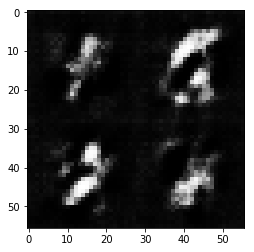

Epoch 1/0... Discriminator Loss: 1.1877... Generator Loss: 1.0252
Epoch 1/0... Discriminator Loss: 1.2896... Generator Loss: 1.2082
Epoch 1/0... Discriminator Loss: 1.1611... Generator Loss: 0.9714
Epoch 1/0... Discriminator Loss: 1.0899... Generator Loss: 1.1225
Epoch 1/0... Discriminator Loss: 1.1153... Generator Loss: 0.6736
Epoch 1/0... Discriminator Loss: 1.1019... Generator Loss: 0.8170
Epoch 1/0... Discriminator Loss: 1.0808... Generator Loss: 0.7121
Epoch 1/0... Discriminator Loss: 1.1032... Generator Loss: 1.1521
Epoch 1/0... Discriminator Loss: 1.1116... Generator Loss: 0.7376
Epoch 1/0... Discriminator Loss: 1.0366... Generator Loss: 0.7607


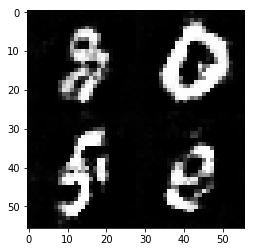

Epoch 1/0... Discriminator Loss: 1.0614... Generator Loss: 0.6717
Epoch 1/0... Discriminator Loss: 0.9675... Generator Loss: 0.8393
Epoch 1/0... Discriminator Loss: 1.0752... Generator Loss: 1.4955
Epoch 1/0... Discriminator Loss: 1.1077... Generator Loss: 1.0248
Epoch 1/0... Discriminator Loss: 1.0275... Generator Loss: 1.5092
Epoch 1/0... Discriminator Loss: 0.8940... Generator Loss: 0.9881
Epoch 1/0... Discriminator Loss: 0.8462... Generator Loss: 0.9710
Epoch 1/0... Discriminator Loss: 0.9427... Generator Loss: 0.9203
Epoch 1/0... Discriminator Loss: 1.0038... Generator Loss: 1.1258
Epoch 1/0... Discriminator Loss: 0.9678... Generator Loss: 0.7609


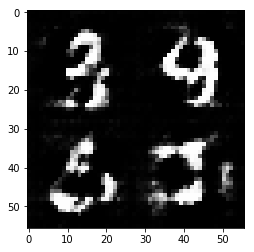

Epoch 1/0... Discriminator Loss: 0.8850... Generator Loss: 1.1465
Epoch 1/0... Discriminator Loss: 0.9977... Generator Loss: 1.5143
Epoch 1/0... Discriminator Loss: 0.9110... Generator Loss: 1.1509
Epoch 1/0... Discriminator Loss: 0.9428... Generator Loss: 0.8936
Epoch 1/0... Discriminator Loss: 0.9497... Generator Loss: 1.0259
Epoch 1/0... Discriminator Loss: 0.9566... Generator Loss: 1.3606
Epoch 2/1... Discriminator Loss: 1.1007... Generator Loss: 0.6653
Epoch 2/1... Discriminator Loss: 0.9848... Generator Loss: 1.0246
Epoch 2/1... Discriminator Loss: 0.9571... Generator Loss: 1.1961
Epoch 2/1... Discriminator Loss: 0.9962... Generator Loss: 1.1046


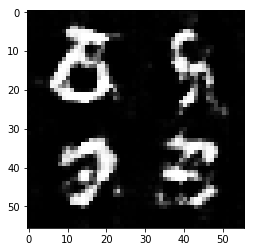

Epoch 2/1... Discriminator Loss: 1.0354... Generator Loss: 0.6706
Epoch 2/1... Discriminator Loss: 0.9975... Generator Loss: 0.7838
Epoch 2/1... Discriminator Loss: 1.1849... Generator Loss: 1.4534
Epoch 2/1... Discriminator Loss: 1.0214... Generator Loss: 1.4629
Epoch 2/1... Discriminator Loss: 0.9858... Generator Loss: 0.9978
Epoch 2/1... Discriminator Loss: 1.0467... Generator Loss: 0.7190
Epoch 2/1... Discriminator Loss: 0.9806... Generator Loss: 1.0454
Epoch 2/1... Discriminator Loss: 1.1974... Generator Loss: 1.5519
Epoch 2/1... Discriminator Loss: 1.1192... Generator Loss: 0.6578
Epoch 2/1... Discriminator Loss: 1.0239... Generator Loss: 0.7231


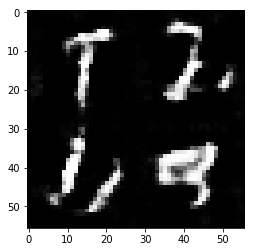

Epoch 2/1... Discriminator Loss: 1.0598... Generator Loss: 0.7484
Epoch 2/1... Discriminator Loss: 1.0544... Generator Loss: 1.2812
Epoch 2/1... Discriminator Loss: 1.1595... Generator Loss: 0.5839
Epoch 2/1... Discriminator Loss: 1.2176... Generator Loss: 1.3143
Epoch 2/1... Discriminator Loss: 1.0860... Generator Loss: 0.7187
Epoch 2/1... Discriminator Loss: 1.0872... Generator Loss: 0.8405
Epoch 2/1... Discriminator Loss: 1.2725... Generator Loss: 1.5403
Epoch 2/1... Discriminator Loss: 1.0983... Generator Loss: 0.6990
Epoch 2/1... Discriminator Loss: 1.2364... Generator Loss: 0.4783
Epoch 2/1... Discriminator Loss: 1.1245... Generator Loss: 1.1918


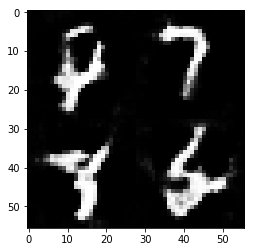

Epoch 2/1... Discriminator Loss: 1.1497... Generator Loss: 0.6143
Epoch 2/1... Discriminator Loss: 1.1024... Generator Loss: 1.2275
Epoch 2/1... Discriminator Loss: 1.0743... Generator Loss: 0.7933
Epoch 2/1... Discriminator Loss: 1.0894... Generator Loss: 0.8052
Epoch 2/1... Discriminator Loss: 1.2288... Generator Loss: 0.5439
Epoch 2/1... Discriminator Loss: 1.2286... Generator Loss: 0.5268
Epoch 2/1... Discriminator Loss: 1.0273... Generator Loss: 0.9102
Epoch 2/1... Discriminator Loss: 1.1608... Generator Loss: 0.6211
Epoch 2/1... Discriminator Loss: 1.0709... Generator Loss: 1.2092
Epoch 2/1... Discriminator Loss: 1.2332... Generator Loss: 0.5589


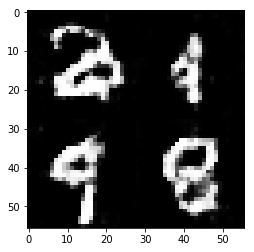

Epoch 2/1... Discriminator Loss: 1.1127... Generator Loss: 0.7238
Epoch 2/1... Discriminator Loss: 1.0949... Generator Loss: 1.0850
Epoch 2/1... Discriminator Loss: 1.0865... Generator Loss: 0.7515
Epoch 2/1... Discriminator Loss: 1.0770... Generator Loss: 0.7137
Epoch 2/1... Discriminator Loss: 1.0265... Generator Loss: 1.1127
Epoch 2/1... Discriminator Loss: 1.1089... Generator Loss: 1.0478
Epoch 2/1... Discriminator Loss: 1.0966... Generator Loss: 1.1646
Epoch 2/1... Discriminator Loss: 1.0464... Generator Loss: 0.8858
Epoch 2/1... Discriminator Loss: 1.0874... Generator Loss: 0.7822
Epoch 2/1... Discriminator Loss: 1.0622... Generator Loss: 0.8087


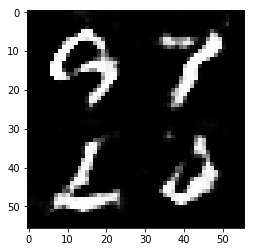

Epoch 2/1... Discriminator Loss: 1.0585... Generator Loss: 0.6969
Epoch 2/1... Discriminator Loss: 1.0934... Generator Loss: 0.9123
Epoch 2/1... Discriminator Loss: 1.0237... Generator Loss: 0.8590


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/0... Discriminator Loss: 0.7774... Generator Loss: 2.0254
Epoch 1/0... Discriminator Loss: 0.7360... Generator Loss: 2.3226
Epoch 1/0... Discriminator Loss: 0.6819... Generator Loss: 3.1623
Epoch 1/0... Discriminator Loss: 0.6015... Generator Loss: 2.7366
Epoch 1/0... Discriminator Loss: 0.7702... Generator Loss: 1.5113
Epoch 1/0... Discriminator Loss: 1.6566... Generator Loss: 9.0769
Epoch 1/0... Discriminator Loss: 0.6090... Generator Loss: 4.4314
Epoch 1/0... Discriminator Loss: 0.7149... Generator Loss: 4.0247
Epoch 1/0... Discriminator Loss: 0.6827... Generator Loss: 2.7181
Epoch 1/0... Discriminator Loss: 0.6169... Generator Loss: 3.4706


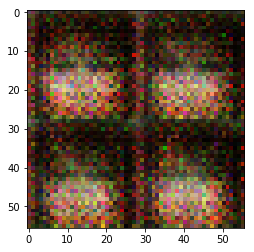

Epoch 1/0... Discriminator Loss: 0.5435... Generator Loss: 4.3482
Epoch 1/0... Discriminator Loss: 0.5412... Generator Loss: 3.3736
Epoch 1/0... Discriminator Loss: 0.5311... Generator Loss: 2.8336
Epoch 1/0... Discriminator Loss: 0.5397... Generator Loss: 2.8375
Epoch 1/0... Discriminator Loss: 0.5106... Generator Loss: 2.9931
Epoch 1/0... Discriminator Loss: 0.4503... Generator Loss: 3.8981
Epoch 1/0... Discriminator Loss: 0.4464... Generator Loss: 4.0845
Epoch 1/0... Discriminator Loss: 0.4847... Generator Loss: 2.9463
Epoch 1/0... Discriminator Loss: 0.4099... Generator Loss: 4.0315
Epoch 1/0... Discriminator Loss: 0.4636... Generator Loss: 3.4254


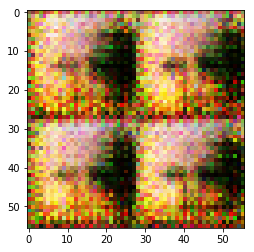

Epoch 1/0... Discriminator Loss: 0.4854... Generator Loss: 4.1585
Epoch 1/0... Discriminator Loss: 0.4298... Generator Loss: 3.5379
Epoch 1/0... Discriminator Loss: 0.4229... Generator Loss: 3.7432
Epoch 1/0... Discriminator Loss: 0.4465... Generator Loss: 4.1201
Epoch 1/0... Discriminator Loss: 0.4365... Generator Loss: 3.5392
Epoch 1/0... Discriminator Loss: 0.4001... Generator Loss: 3.7119
Epoch 1/0... Discriminator Loss: 0.3873... Generator Loss: 4.1364
Epoch 1/0... Discriminator Loss: 0.4074... Generator Loss: 4.2369
Epoch 1/0... Discriminator Loss: 0.4251... Generator Loss: 3.5067
Epoch 1/0... Discriminator Loss: 0.4443... Generator Loss: 3.0697


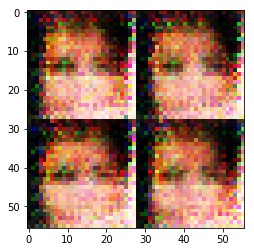

Epoch 1/0... Discriminator Loss: 0.4445... Generator Loss: 3.2317
Epoch 1/0... Discriminator Loss: 0.4897... Generator Loss: 3.9215
Epoch 1/0... Discriminator Loss: 0.6190... Generator Loss: 3.5042
Epoch 1/0... Discriminator Loss: 0.9300... Generator Loss: 1.3987
Epoch 1/0... Discriminator Loss: 0.5487... Generator Loss: 2.2441
Epoch 1/0... Discriminator Loss: 0.5609... Generator Loss: 3.5132
Epoch 1/0... Discriminator Loss: 0.5472... Generator Loss: 2.6940
Epoch 1/0... Discriminator Loss: 1.4182... Generator Loss: 9.1124
Epoch 1/0... Discriminator Loss: 0.7667... Generator Loss: 1.7185
Epoch 1/0... Discriminator Loss: 0.6189... Generator Loss: 1.8954


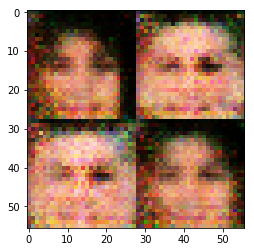

Epoch 1/0... Discriminator Loss: 0.4900... Generator Loss: 2.4649
Epoch 1/0... Discriminator Loss: 0.4326... Generator Loss: 3.4409
Epoch 1/0... Discriminator Loss: 0.5118... Generator Loss: 2.5264
Epoch 1/0... Discriminator Loss: 0.5039... Generator Loss: 3.3125
Epoch 1/0... Discriminator Loss: 1.1652... Generator Loss: 3.3697
Epoch 1/0... Discriminator Loss: 1.0280... Generator Loss: 5.1330
Epoch 1/0... Discriminator Loss: 0.4885... Generator Loss: 3.2824
Epoch 1/0... Discriminator Loss: 0.5419... Generator Loss: 2.5581
Epoch 1/0... Discriminator Loss: 0.5575... Generator Loss: 2.9794
Epoch 1/0... Discriminator Loss: 0.5629... Generator Loss: 2.2851


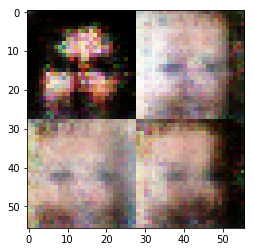

Epoch 1/0... Discriminator Loss: 0.6097... Generator Loss: 3.4118
Epoch 1/0... Discriminator Loss: 0.5395... Generator Loss: 2.8463
Epoch 1/0... Discriminator Loss: 0.6061... Generator Loss: 2.4459
Epoch 1/0... Discriminator Loss: 0.5067... Generator Loss: 2.9527
Epoch 1/0... Discriminator Loss: 0.8804... Generator Loss: 3.0594
Epoch 1/0... Discriminator Loss: 0.7134... Generator Loss: 3.1390
Epoch 1/0... Discriminator Loss: 1.0740... Generator Loss: 3.7674
Epoch 1/0... Discriminator Loss: 0.8689... Generator Loss: 1.3194
Epoch 1/0... Discriminator Loss: 0.7509... Generator Loss: 2.1094
Epoch 1/0... Discriminator Loss: 0.6798... Generator Loss: 1.9319


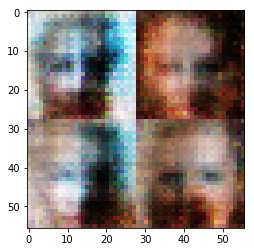

Epoch 1/0... Discriminator Loss: 0.7517... Generator Loss: 1.7385
Epoch 1/0... Discriminator Loss: 0.6615... Generator Loss: 2.6367
Epoch 1/0... Discriminator Loss: 0.8035... Generator Loss: 2.3891
Epoch 1/0... Discriminator Loss: 0.6320... Generator Loss: 2.5013
Epoch 1/0... Discriminator Loss: 0.7316... Generator Loss: 2.1022
Epoch 1/0... Discriminator Loss: 0.6055... Generator Loss: 2.3807
Epoch 1/0... Discriminator Loss: 0.7474... Generator Loss: 1.7492
Epoch 1/0... Discriminator Loss: 1.1033... Generator Loss: 1.0705
Epoch 1/0... Discriminator Loss: 0.6854... Generator Loss: 2.0151
Epoch 1/0... Discriminator Loss: 0.7589... Generator Loss: 1.8393


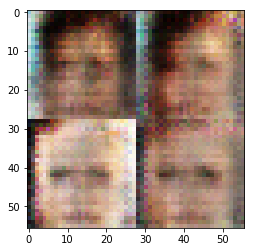

Epoch 1/0... Discriminator Loss: 0.6610... Generator Loss: 2.1666
Epoch 1/0... Discriminator Loss: 0.6184... Generator Loss: 2.2237
Epoch 1/0... Discriminator Loss: 0.7691... Generator Loss: 1.8651
Epoch 1/0... Discriminator Loss: 0.9123... Generator Loss: 1.9905
Epoch 1/0... Discriminator Loss: 0.7308... Generator Loss: 2.0190
Epoch 1/0... Discriminator Loss: 0.5686... Generator Loss: 2.4161
Epoch 1/0... Discriminator Loss: 0.8619... Generator Loss: 1.6363
Epoch 1/0... Discriminator Loss: 1.2128... Generator Loss: 2.3971
Epoch 1/0... Discriminator Loss: 0.8924... Generator Loss: 1.7232
Epoch 1/0... Discriminator Loss: 0.7840... Generator Loss: 1.8650


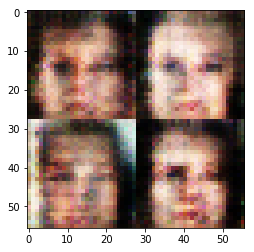

Epoch 1/0... Discriminator Loss: 1.3026... Generator Loss: 0.8056
Epoch 1/0... Discriminator Loss: 0.8947... Generator Loss: 1.9792
Epoch 1/0... Discriminator Loss: 1.0471... Generator Loss: 2.3448
Epoch 1/0... Discriminator Loss: 0.7929... Generator Loss: 1.9600
Epoch 1/0... Discriminator Loss: 0.9323... Generator Loss: 1.3139
Epoch 1/0... Discriminator Loss: 1.0512... Generator Loss: 1.5477
Epoch 1/0... Discriminator Loss: 0.8603... Generator Loss: 2.0320
Epoch 1/0... Discriminator Loss: 1.0294... Generator Loss: 1.0265
Epoch 1/0... Discriminator Loss: 0.7369... Generator Loss: 2.6112
Epoch 1/0... Discriminator Loss: 0.8748... Generator Loss: 2.1839


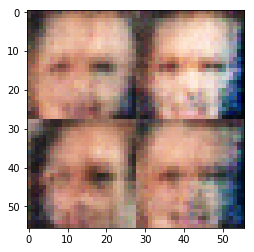

Epoch 1/0... Discriminator Loss: 0.8476... Generator Loss: 2.8588
Epoch 1/0... Discriminator Loss: 0.9023... Generator Loss: 1.6082
Epoch 1/0... Discriminator Loss: 0.8348... Generator Loss: 1.6292
Epoch 1/0... Discriminator Loss: 1.0225... Generator Loss: 1.3483
Epoch 1/0... Discriminator Loss: 0.7060... Generator Loss: 2.3226
Epoch 1/0... Discriminator Loss: 0.7982... Generator Loss: 1.9268
Epoch 1/0... Discriminator Loss: 0.9322... Generator Loss: 1.5606
Epoch 1/0... Discriminator Loss: 0.9746... Generator Loss: 1.3031
Epoch 1/0... Discriminator Loss: 0.8504... Generator Loss: 1.6025
Epoch 1/0... Discriminator Loss: 0.8596... Generator Loss: 1.4803


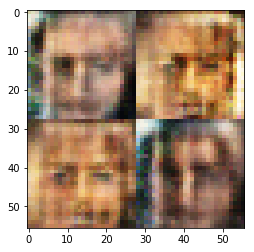

Epoch 1/0... Discriminator Loss: 0.7721... Generator Loss: 2.0067
Epoch 1/0... Discriminator Loss: 0.8935... Generator Loss: 1.5497
Epoch 1/0... Discriminator Loss: 0.8288... Generator Loss: 1.6893
Epoch 1/0... Discriminator Loss: 0.8236... Generator Loss: 2.1589
Epoch 1/0... Discriminator Loss: 0.8308... Generator Loss: 1.7760
Epoch 1/0... Discriminator Loss: 0.8950... Generator Loss: 1.5082
Epoch 1/0... Discriminator Loss: 1.0444... Generator Loss: 1.4383
Epoch 1/0... Discriminator Loss: 0.8272... Generator Loss: 1.8845
Epoch 1/0... Discriminator Loss: 1.0965... Generator Loss: 1.1403
Epoch 1/0... Discriminator Loss: 0.8804... Generator Loss: 2.0164


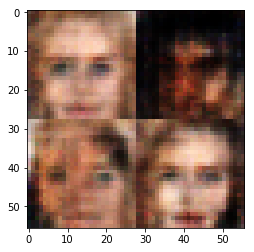

Epoch 1/0... Discriminator Loss: 0.9410... Generator Loss: 1.4688
Epoch 1/0... Discriminator Loss: 0.9314... Generator Loss: 1.4867
Epoch 1/0... Discriminator Loss: 1.0070... Generator Loss: 1.3814
Epoch 1/0... Discriminator Loss: 1.1092... Generator Loss: 1.1069
Epoch 1/0... Discriminator Loss: 1.2244... Generator Loss: 2.4975
Epoch 1/0... Discriminator Loss: 1.3167... Generator Loss: 0.9819
Epoch 1/0... Discriminator Loss: 0.9834... Generator Loss: 1.6306
Epoch 1/0... Discriminator Loss: 1.0336... Generator Loss: 1.2691
Epoch 1/0... Discriminator Loss: 1.0067... Generator Loss: 1.8141
Epoch 1/0... Discriminator Loss: 1.0056... Generator Loss: 1.4130


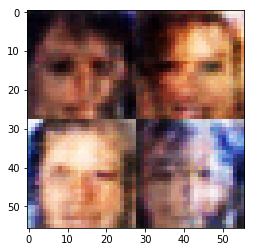

Epoch 1/0... Discriminator Loss: 0.9851... Generator Loss: 1.9088
Epoch 1/0... Discriminator Loss: 1.2212... Generator Loss: 1.2554
Epoch 1/0... Discriminator Loss: 1.0066... Generator Loss: 1.3681
Epoch 1/0... Discriminator Loss: 0.8894... Generator Loss: 1.6124
Epoch 1/0... Discriminator Loss: 0.8251... Generator Loss: 1.5882
Epoch 1/0... Discriminator Loss: 1.0186... Generator Loss: 1.1669
Epoch 1/0... Discriminator Loss: 0.9426... Generator Loss: 1.4546
Epoch 1/0... Discriminator Loss: 0.8981... Generator Loss: 1.9459
Epoch 1/0... Discriminator Loss: 0.8932... Generator Loss: 2.2809
Epoch 1/0... Discriminator Loss: 0.8696... Generator Loss: 1.5331


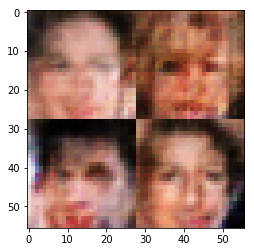

Epoch 1/0... Discriminator Loss: 0.8590... Generator Loss: 2.0684
Epoch 1/0... Discriminator Loss: 1.1592... Generator Loss: 0.9267
Epoch 1/0... Discriminator Loss: 0.9687... Generator Loss: 1.3676
Epoch 1/0... Discriminator Loss: 1.0190... Generator Loss: 2.3070
Epoch 1/0... Discriminator Loss: 0.9588... Generator Loss: 1.3588
Epoch 1/0... Discriminator Loss: 0.8863... Generator Loss: 1.7302
Epoch 1/0... Discriminator Loss: 1.0955... Generator Loss: 1.1321
Epoch 1/0... Discriminator Loss: 0.8929... Generator Loss: 1.4796
Epoch 1/0... Discriminator Loss: 1.0680... Generator Loss: 1.5202
Epoch 1/0... Discriminator Loss: 0.9731... Generator Loss: 1.6461


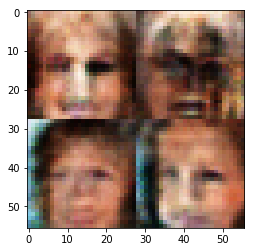

Epoch 1/0... Discriminator Loss: 0.8919... Generator Loss: 1.5350
Epoch 1/0... Discriminator Loss: 0.9327... Generator Loss: 1.6721
Epoch 1/0... Discriminator Loss: 0.9329... Generator Loss: 1.6569
Epoch 1/0... Discriminator Loss: 1.0197... Generator Loss: 1.7035
Epoch 1/0... Discriminator Loss: 1.0072... Generator Loss: 2.0181
Epoch 1/0... Discriminator Loss: 0.9322... Generator Loss: 1.3781
Epoch 1/0... Discriminator Loss: 0.9468... Generator Loss: 1.6233
Epoch 1/0... Discriminator Loss: 0.8507... Generator Loss: 2.2901
Epoch 1/0... Discriminator Loss: 1.1069... Generator Loss: 2.1375
Epoch 1/0... Discriminator Loss: 1.0884... Generator Loss: 2.4365


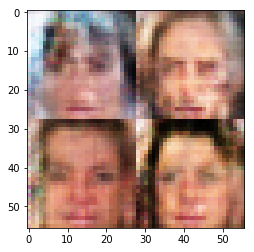

Epoch 1/0... Discriminator Loss: 0.9725... Generator Loss: 1.6069
Epoch 1/0... Discriminator Loss: 0.9053... Generator Loss: 1.5617
Epoch 1/0... Discriminator Loss: 1.0099... Generator Loss: 1.0080
Epoch 1/0... Discriminator Loss: 0.7726... Generator Loss: 1.7921
Epoch 1/0... Discriminator Loss: 0.9163... Generator Loss: 1.5720
Epoch 1/0... Discriminator Loss: 0.8952... Generator Loss: 2.2235
Epoch 1/0... Discriminator Loss: 0.9569... Generator Loss: 1.5642
Epoch 1/0... Discriminator Loss: 0.8906... Generator Loss: 1.4451
Epoch 2/1... Discriminator Loss: 0.7804... Generator Loss: 1.4274
Epoch 2/1... Discriminator Loss: 1.1494... Generator Loss: 0.9570


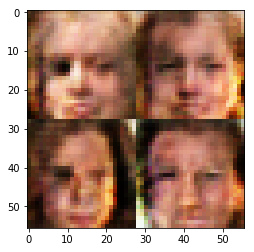

Epoch 2/1... Discriminator Loss: 1.1049... Generator Loss: 1.1088
Epoch 2/1... Discriminator Loss: 0.7282... Generator Loss: 2.3243
Epoch 2/1... Discriminator Loss: 0.9206... Generator Loss: 1.6378
Epoch 2/1... Discriminator Loss: 0.8844... Generator Loss: 1.8844
Epoch 2/1... Discriminator Loss: 0.9748... Generator Loss: 0.9848
Epoch 2/1... Discriminator Loss: 0.9397... Generator Loss: 1.5018
Epoch 2/1... Discriminator Loss: 0.8517... Generator Loss: 1.5120
Epoch 2/1... Discriminator Loss: 1.0027... Generator Loss: 1.1694
Epoch 2/1... Discriminator Loss: 1.1497... Generator Loss: 1.0608
Epoch 2/1... Discriminator Loss: 0.7744... Generator Loss: 1.6071


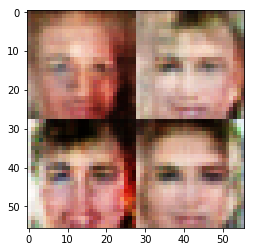

Epoch 2/1... Discriminator Loss: 0.7464... Generator Loss: 2.1539
Epoch 2/1... Discriminator Loss: 1.0395... Generator Loss: 0.9709
Epoch 2/1... Discriminator Loss: 0.8901... Generator Loss: 1.3060
Epoch 2/1... Discriminator Loss: 0.8505... Generator Loss: 1.8007
Epoch 2/1... Discriminator Loss: 0.9648... Generator Loss: 1.6712
Epoch 2/1... Discriminator Loss: 0.8812... Generator Loss: 1.6786
Epoch 2/1... Discriminator Loss: 0.9301... Generator Loss: 1.5414
Epoch 2/1... Discriminator Loss: 1.0460... Generator Loss: 1.2086
Epoch 2/1... Discriminator Loss: 0.9556... Generator Loss: 1.4300
Epoch 2/1... Discriminator Loss: 0.9553... Generator Loss: 1.7200


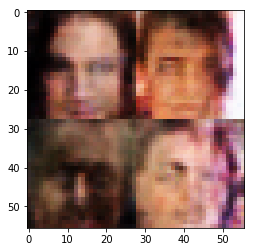

Epoch 2/1... Discriminator Loss: 0.8942... Generator Loss: 1.6173
Epoch 2/1... Discriminator Loss: 0.9008... Generator Loss: 2.0391
Epoch 2/1... Discriminator Loss: 0.8086... Generator Loss: 1.4235
Epoch 2/1... Discriminator Loss: 0.9566... Generator Loss: 1.7270
Epoch 2/1... Discriminator Loss: 0.8842... Generator Loss: 1.4112
Epoch 2/1... Discriminator Loss: 0.7280... Generator Loss: 2.0261
Epoch 2/1... Discriminator Loss: 1.1537... Generator Loss: 1.1810
Epoch 2/1... Discriminator Loss: 0.8940... Generator Loss: 1.6809
Epoch 2/1... Discriminator Loss: 0.9182... Generator Loss: 1.7614
Epoch 2/1... Discriminator Loss: 0.9418... Generator Loss: 1.2861


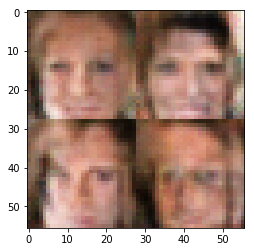

Epoch 2/1... Discriminator Loss: 0.7338... Generator Loss: 1.8862
Epoch 2/1... Discriminator Loss: 0.8664... Generator Loss: 1.2051
Epoch 2/1... Discriminator Loss: 0.8973... Generator Loss: 1.2257
Epoch 2/1... Discriminator Loss: 0.8564... Generator Loss: 2.1109
Epoch 2/1... Discriminator Loss: 0.8960... Generator Loss: 1.2657
Epoch 2/1... Discriminator Loss: 1.0330... Generator Loss: 1.2821
Epoch 2/1... Discriminator Loss: 0.8577... Generator Loss: 1.3857
Epoch 2/1... Discriminator Loss: 1.1974... Generator Loss: 0.7537
Epoch 2/1... Discriminator Loss: 0.9721... Generator Loss: 1.2729
Epoch 2/1... Discriminator Loss: 0.9532... Generator Loss: 1.9283


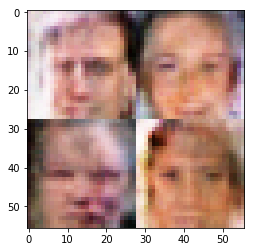

Epoch 2/1... Discriminator Loss: 0.8591... Generator Loss: 1.9145
Epoch 2/1... Discriminator Loss: 0.8138... Generator Loss: 1.2199
Epoch 2/1... Discriminator Loss: 1.0326... Generator Loss: 1.1520
Epoch 2/1... Discriminator Loss: 0.8515... Generator Loss: 1.8896
Epoch 2/1... Discriminator Loss: 1.2028... Generator Loss: 0.9497
Epoch 2/1... Discriminator Loss: 1.0328... Generator Loss: 1.4097
Epoch 2/1... Discriminator Loss: 1.3402... Generator Loss: 0.6057
Epoch 2/1... Discriminator Loss: 1.0126... Generator Loss: 1.2616
Epoch 2/1... Discriminator Loss: 1.1193... Generator Loss: 0.9636
Epoch 2/1... Discriminator Loss: 1.0093... Generator Loss: 1.2854


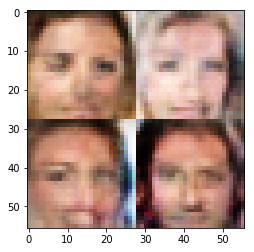

Epoch 2/1... Discriminator Loss: 1.0886... Generator Loss: 1.1879
Epoch 2/1... Discriminator Loss: 0.8746... Generator Loss: 1.9240
Epoch 2/1... Discriminator Loss: 1.0163... Generator Loss: 0.9757
Epoch 2/1... Discriminator Loss: 0.9979... Generator Loss: 1.0096
Epoch 2/1... Discriminator Loss: 1.0395... Generator Loss: 1.0729
Epoch 2/1... Discriminator Loss: 1.0077... Generator Loss: 1.2113
Epoch 2/1... Discriminator Loss: 0.9383... Generator Loss: 1.3982
Epoch 2/1... Discriminator Loss: 0.9362... Generator Loss: 1.2817
Epoch 2/1... Discriminator Loss: 0.9756... Generator Loss: 1.6684
Epoch 2/1... Discriminator Loss: 0.9560... Generator Loss: 1.6675


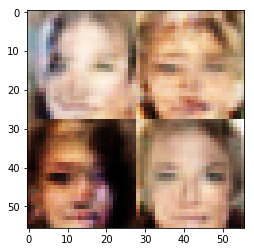

Epoch 2/1... Discriminator Loss: 0.7264... Generator Loss: 1.8328
Epoch 2/1... Discriminator Loss: 1.0044... Generator Loss: 1.5473
Epoch 2/1... Discriminator Loss: 0.9335... Generator Loss: 1.3126
Epoch 2/1... Discriminator Loss: 0.7643... Generator Loss: 1.4722
Epoch 2/1... Discriminator Loss: 0.9459... Generator Loss: 1.4331
Epoch 2/1... Discriminator Loss: 1.1198... Generator Loss: 1.0006
Epoch 2/1... Discriminator Loss: 0.9192... Generator Loss: 1.4693
Epoch 2/1... Discriminator Loss: 0.9723... Generator Loss: 1.0339
Epoch 2/1... Discriminator Loss: 1.0567... Generator Loss: 1.2350
Epoch 2/1... Discriminator Loss: 1.0326... Generator Loss: 1.9542


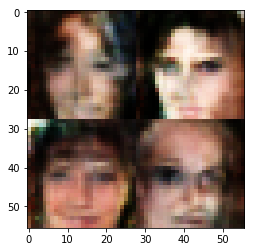

Epoch 2/1... Discriminator Loss: 0.9026... Generator Loss: 1.3955
Epoch 2/1... Discriminator Loss: 0.8739... Generator Loss: 2.1005
Epoch 2/1... Discriminator Loss: 0.9639... Generator Loss: 1.1090
Epoch 2/1... Discriminator Loss: 1.4958... Generator Loss: 0.5810
Epoch 2/1... Discriminator Loss: 0.9224... Generator Loss: 1.5338
Epoch 2/1... Discriminator Loss: 1.0607... Generator Loss: 1.5638
Epoch 2/1... Discriminator Loss: 0.9921... Generator Loss: 1.5203
Epoch 2/1... Discriminator Loss: 0.9604... Generator Loss: 1.1917
Epoch 2/1... Discriminator Loss: 0.9501... Generator Loss: 1.3083
Epoch 2/1... Discriminator Loss: 0.9490... Generator Loss: 1.6503


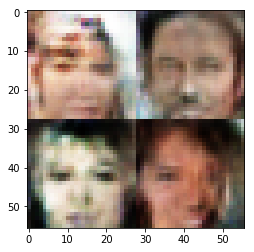

Epoch 2/1... Discriminator Loss: 0.8277... Generator Loss: 1.5768
Epoch 2/1... Discriminator Loss: 0.9499... Generator Loss: 1.9348
Epoch 2/1... Discriminator Loss: 0.9910... Generator Loss: 1.0898
Epoch 2/1... Discriminator Loss: 0.9602... Generator Loss: 1.3718
Epoch 2/1... Discriminator Loss: 0.8833... Generator Loss: 1.2630
Epoch 2/1... Discriminator Loss: 1.0774... Generator Loss: 2.1643
Epoch 2/1... Discriminator Loss: 1.1293... Generator Loss: 0.9577
Epoch 2/1... Discriminator Loss: 0.8961... Generator Loss: 1.2225
Epoch 2/1... Discriminator Loss: 0.9723... Generator Loss: 1.7500
Epoch 2/1... Discriminator Loss: 0.9242... Generator Loss: 1.2348


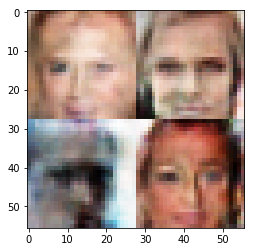

Epoch 2/1... Discriminator Loss: 0.9246... Generator Loss: 1.4838
Epoch 2/1... Discriminator Loss: 0.9663... Generator Loss: 1.1913
Epoch 2/1... Discriminator Loss: 1.0268... Generator Loss: 1.0567
Epoch 2/1... Discriminator Loss: 0.8843... Generator Loss: 1.5661
Epoch 2/1... Discriminator Loss: 1.2318... Generator Loss: 0.7939
Epoch 2/1... Discriminator Loss: 0.9176... Generator Loss: 1.2491
Epoch 2/1... Discriminator Loss: 0.8278... Generator Loss: 1.9710
Epoch 2/1... Discriminator Loss: 0.9578... Generator Loss: 1.6394
Epoch 2/1... Discriminator Loss: 0.8786... Generator Loss: 2.0931
Epoch 2/1... Discriminator Loss: 0.8751... Generator Loss: 1.3888


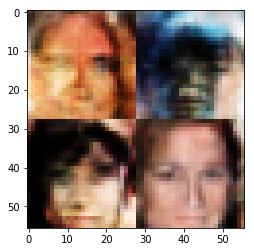

Epoch 2/1... Discriminator Loss: 0.9461... Generator Loss: 1.4386
Epoch 2/1... Discriminator Loss: 0.9823... Generator Loss: 1.7411
Epoch 2/1... Discriminator Loss: 0.8511... Generator Loss: 1.4396
Epoch 2/1... Discriminator Loss: 0.9749... Generator Loss: 1.5629
Epoch 2/1... Discriminator Loss: 0.9884... Generator Loss: 1.5520
Epoch 2/1... Discriminator Loss: 0.8827... Generator Loss: 1.5569
Epoch 2/1... Discriminator Loss: 1.1144... Generator Loss: 2.0693
Epoch 2/1... Discriminator Loss: 1.0920... Generator Loss: 1.3916
Epoch 2/1... Discriminator Loss: 0.8512... Generator Loss: 1.7617
Epoch 2/1... Discriminator Loss: 0.9468... Generator Loss: 1.4050


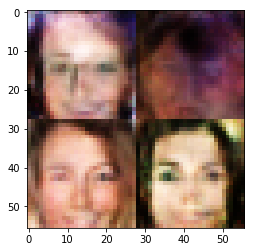

Epoch 2/1... Discriminator Loss: 0.9389... Generator Loss: 1.2620
Epoch 2/1... Discriminator Loss: 1.1430... Generator Loss: 1.0000
Epoch 2/1... Discriminator Loss: 0.9258... Generator Loss: 1.3045
Epoch 2/1... Discriminator Loss: 1.0967... Generator Loss: 0.9816
Epoch 2/1... Discriminator Loss: 1.0538... Generator Loss: 1.7858
Epoch 2/1... Discriminator Loss: 0.9245... Generator Loss: 1.8389
Epoch 2/1... Discriminator Loss: 0.9741... Generator Loss: 1.1829
Epoch 2/1... Discriminator Loss: 0.9055... Generator Loss: 1.4010
Epoch 2/1... Discriminator Loss: 0.9183... Generator Loss: 1.3251
Epoch 2/1... Discriminator Loss: 0.9942... Generator Loss: 1.1699


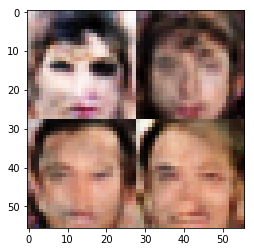

Epoch 2/1... Discriminator Loss: 0.9142... Generator Loss: 1.4143
Epoch 2/1... Discriminator Loss: 0.8434... Generator Loss: 1.1451
Epoch 2/1... Discriminator Loss: 0.9509... Generator Loss: 1.7569
Epoch 2/1... Discriminator Loss: 1.0361... Generator Loss: 1.1628
Epoch 2/1... Discriminator Loss: 1.0946... Generator Loss: 0.9426
Epoch 2/1... Discriminator Loss: 1.0138... Generator Loss: 1.3190
Epoch 2/1... Discriminator Loss: 0.9402... Generator Loss: 1.5361
Epoch 2/1... Discriminator Loss: 0.9274... Generator Loss: 1.4871
Epoch 2/1... Discriminator Loss: 1.1312... Generator Loss: 0.9369
Epoch 2/1... Discriminator Loss: 1.0752... Generator Loss: 1.2260


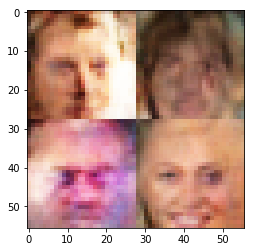

Epoch 2/1... Discriminator Loss: 0.9764... Generator Loss: 1.0440
Epoch 2/1... Discriminator Loss: 0.9556... Generator Loss: 1.4693
Epoch 2/1... Discriminator Loss: 0.8625... Generator Loss: 1.3959
Epoch 2/1... Discriminator Loss: 1.1080... Generator Loss: 2.4339
Epoch 2/1... Discriminator Loss: 0.9497... Generator Loss: 1.2524
Epoch 2/1... Discriminator Loss: 0.8997... Generator Loss: 1.4140
Epoch 2/1... Discriminator Loss: 0.9398... Generator Loss: 1.3994
Epoch 2/1... Discriminator Loss: 0.9030... Generator Loss: 1.6852
Epoch 2/1... Discriminator Loss: 0.9746... Generator Loss: 1.7741
Epoch 2/1... Discriminator Loss: 0.9251... Generator Loss: 1.1046


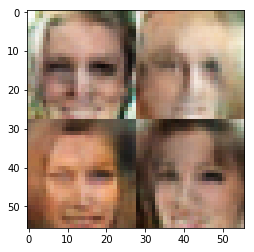

Epoch 2/1... Discriminator Loss: 0.9643... Generator Loss: 1.4025
Epoch 2/1... Discriminator Loss: 0.8578... Generator Loss: 1.2799
Epoch 2/1... Discriminator Loss: 0.9854... Generator Loss: 1.6257
Epoch 2/1... Discriminator Loss: 0.8292... Generator Loss: 1.4094
Epoch 2/1... Discriminator Loss: 0.9635... Generator Loss: 1.8757
Epoch 2/1... Discriminator Loss: 0.9861... Generator Loss: 1.0100
Epoch 2/1... Discriminator Loss: 1.0022... Generator Loss: 1.6661
Epoch 2/1... Discriminator Loss: 0.8567... Generator Loss: 1.3397
Epoch 2/1... Discriminator Loss: 1.1457... Generator Loss: 0.8574
Epoch 2/1... Discriminator Loss: 1.1360... Generator Loss: 0.9118


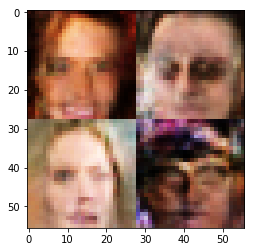

Epoch 2/1... Discriminator Loss: 0.9280... Generator Loss: 1.1691
Epoch 2/1... Discriminator Loss: 0.9656... Generator Loss: 1.4347
Epoch 2/1... Discriminator Loss: 0.9366... Generator Loss: 1.2516
Epoch 2/1... Discriminator Loss: 0.8718... Generator Loss: 1.4742
Epoch 2/1... Discriminator Loss: 0.8671... Generator Loss: 1.4959
Epoch 2/1... Discriminator Loss: 0.9436... Generator Loss: 1.2216
Epoch 3/2... Discriminator Loss: 0.8929... Generator Loss: 1.5645
Epoch 3/2... Discriminator Loss: 1.0021... Generator Loss: 0.9732
Epoch 3/2... Discriminator Loss: 0.9944... Generator Loss: 1.1610
Epoch 3/2... Discriminator Loss: 0.8298... Generator Loss: 1.5308


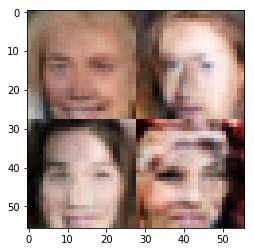

Epoch 3/2... Discriminator Loss: 0.9981... Generator Loss: 1.0233
Epoch 3/2... Discriminator Loss: 1.0851... Generator Loss: 1.0704
Epoch 3/2... Discriminator Loss: 0.9336... Generator Loss: 1.2289
Epoch 3/2... Discriminator Loss: 1.0622... Generator Loss: 1.0139
Epoch 3/2... Discriminator Loss: 0.8621... Generator Loss: 1.3269
Epoch 3/2... Discriminator Loss: 1.0254... Generator Loss: 0.8419
Epoch 3/2... Discriminator Loss: 0.9630... Generator Loss: 1.5372
Epoch 3/2... Discriminator Loss: 0.9551... Generator Loss: 2.1997
Epoch 3/2... Discriminator Loss: 0.8928... Generator Loss: 1.4123
Epoch 3/2... Discriminator Loss: 1.1627... Generator Loss: 0.8228


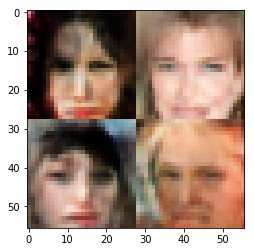

Epoch 3/2... Discriminator Loss: 0.8701... Generator Loss: 1.5244
Epoch 3/2... Discriminator Loss: 0.8823... Generator Loss: 1.2809
Epoch 3/2... Discriminator Loss: 1.0604... Generator Loss: 0.9204
Epoch 3/2... Discriminator Loss: 0.9593... Generator Loss: 1.2399
Epoch 3/2... Discriminator Loss: 0.9222... Generator Loss: 1.8451
Epoch 3/2... Discriminator Loss: 1.2229... Generator Loss: 2.0666
Epoch 3/2... Discriminator Loss: 1.0502... Generator Loss: 0.9806
Epoch 3/2... Discriminator Loss: 1.0636... Generator Loss: 0.9737
Epoch 3/2... Discriminator Loss: 0.9208... Generator Loss: 2.0561
Epoch 3/2... Discriminator Loss: 1.0033... Generator Loss: 1.4816


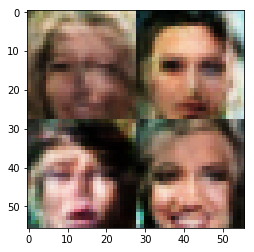

Epoch 3/2... Discriminator Loss: 0.8949... Generator Loss: 1.3093
Epoch 3/2... Discriminator Loss: 0.8930... Generator Loss: 2.1340
Epoch 3/2... Discriminator Loss: 0.9191... Generator Loss: 1.1591
Epoch 3/2... Discriminator Loss: 0.8671... Generator Loss: 1.5133
Epoch 3/2... Discriminator Loss: 0.9715... Generator Loss: 1.3294
Epoch 3/2... Discriminator Loss: 0.9612... Generator Loss: 1.0064
Epoch 3/2... Discriminator Loss: 0.9801... Generator Loss: 1.0671
Epoch 3/2... Discriminator Loss: 0.9386... Generator Loss: 1.5087
Epoch 3/2... Discriminator Loss: 1.0802... Generator Loss: 1.0766
Epoch 3/2... Discriminator Loss: 1.0182... Generator Loss: 1.3281


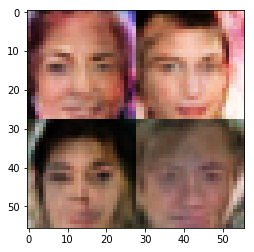

Epoch 3/2... Discriminator Loss: 0.9016... Generator Loss: 1.3966
Epoch 3/2... Discriminator Loss: 0.8797... Generator Loss: 1.5833
Epoch 3/2... Discriminator Loss: 0.9366... Generator Loss: 1.2253
Epoch 3/2... Discriminator Loss: 0.8919... Generator Loss: 1.5630
Epoch 3/2... Discriminator Loss: 1.0401... Generator Loss: 1.0165
Epoch 3/2... Discriminator Loss: 0.8627... Generator Loss: 1.2069
Epoch 3/2... Discriminator Loss: 1.2395... Generator Loss: 0.6766
Epoch 3/2... Discriminator Loss: 0.9471... Generator Loss: 1.5026
Epoch 3/2... Discriminator Loss: 0.8930... Generator Loss: 1.4901
Epoch 3/2... Discriminator Loss: 0.9042... Generator Loss: 1.2488


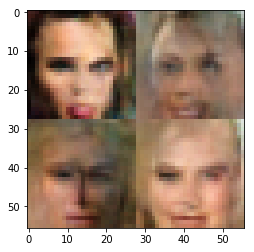

Epoch 3/2... Discriminator Loss: 1.1106... Generator Loss: 1.1645
Epoch 3/2... Discriminator Loss: 1.0259... Generator Loss: 1.5638
Epoch 3/2... Discriminator Loss: 0.8720... Generator Loss: 1.6104
Epoch 3/2... Discriminator Loss: 0.9653... Generator Loss: 1.3887
Epoch 3/2... Discriminator Loss: 0.8567... Generator Loss: 1.4379
Epoch 3/2... Discriminator Loss: 0.9555... Generator Loss: 1.1659
Epoch 3/2... Discriminator Loss: 0.8218... Generator Loss: 1.5235
Epoch 3/2... Discriminator Loss: 1.0008... Generator Loss: 1.4436
Epoch 3/2... Discriminator Loss: 1.0630... Generator Loss: 0.9271
Epoch 3/2... Discriminator Loss: 0.9628... Generator Loss: 1.8434


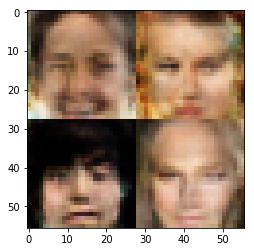

Epoch 3/2... Discriminator Loss: 0.9320... Generator Loss: 1.3824
Epoch 3/2... Discriminator Loss: 1.0072... Generator Loss: 0.9540
Epoch 3/2... Discriminator Loss: 0.9140... Generator Loss: 1.3484
Epoch 3/2... Discriminator Loss: 1.0059... Generator Loss: 0.9169
Epoch 3/2... Discriminator Loss: 0.9544... Generator Loss: 1.1269
Epoch 3/2... Discriminator Loss: 0.8644... Generator Loss: 1.3775
Epoch 3/2... Discriminator Loss: 1.0919... Generator Loss: 1.6563
Epoch 3/2... Discriminator Loss: 0.8559... Generator Loss: 1.4882
Epoch 3/2... Discriminator Loss: 1.0713... Generator Loss: 0.9306
Epoch 3/2... Discriminator Loss: 1.1115... Generator Loss: 0.8658


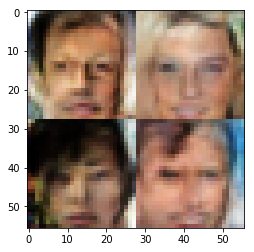

Epoch 3/2... Discriminator Loss: 0.8969... Generator Loss: 1.2847
Epoch 3/2... Discriminator Loss: 1.0219... Generator Loss: 1.0528
Epoch 3/2... Discriminator Loss: 1.0481... Generator Loss: 0.8768
Epoch 3/2... Discriminator Loss: 0.9993... Generator Loss: 1.0341
Epoch 3/2... Discriminator Loss: 1.0753... Generator Loss: 1.9000
Epoch 3/2... Discriminator Loss: 0.8996... Generator Loss: 1.4014
Epoch 3/2... Discriminator Loss: 0.7823... Generator Loss: 1.6574
Epoch 3/2... Discriminator Loss: 0.9866... Generator Loss: 1.0950
Epoch 3/2... Discriminator Loss: 0.7889... Generator Loss: 1.3603
Epoch 3/2... Discriminator Loss: 0.9341... Generator Loss: 1.1169


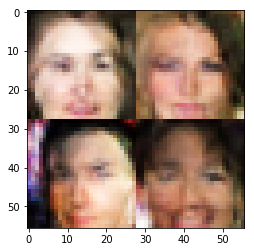

Epoch 3/2... Discriminator Loss: 0.8560... Generator Loss: 1.4883
Epoch 3/2... Discriminator Loss: 1.3696... Generator Loss: 0.6320
Epoch 3/2... Discriminator Loss: 1.1022... Generator Loss: 0.9181
Epoch 3/2... Discriminator Loss: 1.0349... Generator Loss: 1.1072
Epoch 3/2... Discriminator Loss: 0.9203... Generator Loss: 1.7437
Epoch 3/2... Discriminator Loss: 1.0933... Generator Loss: 1.7065
Epoch 3/2... Discriminator Loss: 0.9970... Generator Loss: 1.6007
Epoch 3/2... Discriminator Loss: 1.0254... Generator Loss: 1.7762
Epoch 3/2... Discriminator Loss: 0.8795... Generator Loss: 1.5307
Epoch 3/2... Discriminator Loss: 1.0443... Generator Loss: 1.2418


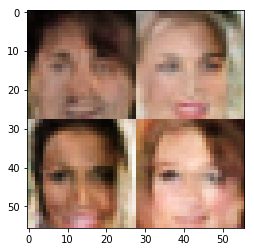

Epoch 3/2... Discriminator Loss: 1.0197... Generator Loss: 1.1050
Epoch 3/2... Discriminator Loss: 0.8665... Generator Loss: 1.6768
Epoch 3/2... Discriminator Loss: 1.0453... Generator Loss: 0.7934
Epoch 3/2... Discriminator Loss: 1.1220... Generator Loss: 2.6460
Epoch 3/2... Discriminator Loss: 0.8955... Generator Loss: 1.6714
Epoch 3/2... Discriminator Loss: 0.9009... Generator Loss: 1.2799
Epoch 3/2... Discriminator Loss: 1.0471... Generator Loss: 1.8675
Epoch 3/2... Discriminator Loss: 0.9778... Generator Loss: 1.4980


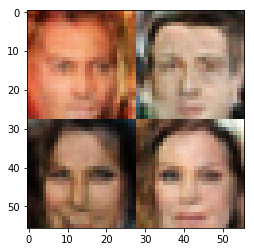

Epoch 3/2... Discriminator Loss: 1.1886... Generator Loss: 0.6479
Epoch 3/2... Discriminator Loss: 1.0064... Generator Loss: 1.4937
Epoch 3/2... Discriminator Loss: 0.9682... Generator Loss: 1.1477
Epoch 3/2... Discriminator Loss: 0.9193... Generator Loss: 1.6910
Epoch 3/2... Discriminator Loss: 0.9438... Generator Loss: 1.9506
Epoch 3/2... Discriminator Loss: 0.8607... Generator Loss: 1.0287
Epoch 3/2... Discriminator Loss: 1.0706... Generator Loss: 0.9390
Epoch 3/2... Discriminator Loss: 0.9603... Generator Loss: 1.8623
Epoch 3/2... Discriminator Loss: 1.0263... Generator Loss: 2.4253
Epoch 3/2... Discriminator Loss: 0.8741... Generator Loss: 1.5296


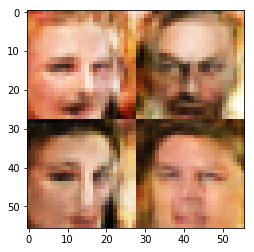

Epoch 3/2... Discriminator Loss: 0.8136... Generator Loss: 2.1604
Epoch 3/2... Discriminator Loss: 1.1406... Generator Loss: 0.7979
Epoch 3/2... Discriminator Loss: 0.9873... Generator Loss: 1.4000
Epoch 3/2... Discriminator Loss: 0.9920... Generator Loss: 1.2333
Epoch 3/2... Discriminator Loss: 0.9058... Generator Loss: 1.3087
Epoch 3/2... Discriminator Loss: 0.9570... Generator Loss: 1.5346
Epoch 3/2... Discriminator Loss: 0.9855... Generator Loss: 1.0911
Epoch 3/2... Discriminator Loss: 0.8267... Generator Loss: 1.7739
Epoch 3/2... Discriminator Loss: 0.9865... Generator Loss: 1.5456
Epoch 3/2... Discriminator Loss: 0.9572... Generator Loss: 1.7156


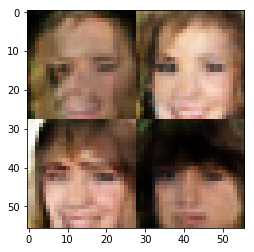

Epoch 3/2... Discriminator Loss: 0.9838... Generator Loss: 1.8308
Epoch 3/2... Discriminator Loss: 1.0435... Generator Loss: 2.0138
Epoch 3/2... Discriminator Loss: 0.8849... Generator Loss: 1.8494
Epoch 3/2... Discriminator Loss: 1.0230... Generator Loss: 0.9639
Epoch 3/2... Discriminator Loss: 1.0593... Generator Loss: 1.9296
Epoch 3/2... Discriminator Loss: 0.9841... Generator Loss: 1.6194
Epoch 3/2... Discriminator Loss: 0.9744... Generator Loss: 1.0732
Epoch 3/2... Discriminator Loss: 0.8627... Generator Loss: 1.5047
Epoch 3/2... Discriminator Loss: 1.0047... Generator Loss: 1.5179
Epoch 3/2... Discriminator Loss: 0.9371... Generator Loss: 1.2179


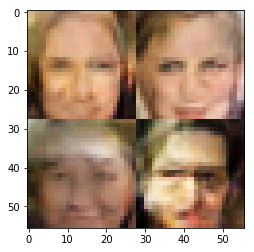

Epoch 3/2... Discriminator Loss: 0.8622... Generator Loss: 1.4841
Epoch 3/2... Discriminator Loss: 0.8932... Generator Loss: 1.8273
Epoch 3/2... Discriminator Loss: 0.7767... Generator Loss: 1.8838
Epoch 3/2... Discriminator Loss: 0.9064... Generator Loss: 1.6350


In [48]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.